# 환경, matplotlib등에 대한 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
X, y = mnist["data"], mnist["target"]

In [7]:
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

그림 저장: some_digit_plot


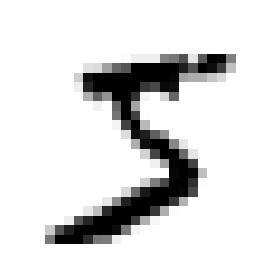

In [9]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

#some_digit = X[0] : 에러가 발생해서 to_numpy()[0]사용
some_digit = X.to_numpy()[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
save_fig("some_digit_plot")
plt.show()

기존 코드는 X[0]을 바로 사용했는데 왜인지 에러가 나서 to_numpy를 사용해 넘파이배열로 한번 바꿔준 후 사용했다. 구글링해보니 같은 오류를 겪는 사람이 좀 있는 것 같다.

In [10]:
y[0]

'5'

In [11]:
y = y.astype(np.uint8)

### 훈련 세트와 테스트 세트 분리

In [12]:
X = X.to_numpy()
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [13]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

5-감지기를 만들기 위해 y값이 5인 경우만 True, 아닌 경우 False로 분류하고 테스트셋을 생성한다

### SGD분류기로 만들기
> 사이킷런의 SGDClassifier클래스를 사용해 확률적 경사하강법 분류기를 만들어보겠다.
SGD분류기는 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문에 온라인 학습에 좋다.

>SGDClassifier는 훈련하는데 무작위성을 사용한다. 그래서 "확률적"이라는 단어가 이름에 들어가고 같은 결과를 재연하고 싶다면 random_state 매개변수를 같게 설정하면 된다.

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

앞서 plot한 '5'를 생성한 분류기도 5가 맞다고 분류한 것을 확인할 수 있다

그림 저장: another_digit


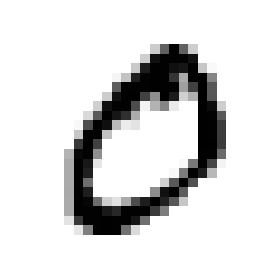

array([False])

In [16]:
another_digit = X[1]
another_digit_image = another_digit.reshape(28, 28)
plt.imshow(another_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
save_fig("another_digit")
plt.show()
sgd_clf.predict([another_digit])

X[1]은 위와 같은 그림을 가지고 있고 이걸로 분류기를 돌려봤을 때 False라고 잘 측정하였다.

## 성능측정
앞 장에서 한 것처럼 교차검증을 통해 방금 만든 sgd_clf 분류기의 성능을 테스트해보려한다.
3개의 훈련세트로 분류하여 서로 교차검증을 시켰고 세 폴드 모두 정확도 95%이상을 유지하였다.

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

반대로 모든 이미지를 '5가 아님'이라고 판단하는 분류기를 만들면 정확도가 어떻게 될까? 이는 굳이 돌려보지 않더라도
정확도를 예측할 수 있다. 전체 이미지의 10%정도만 숫자 5이기 때문에 모든 이미지가 5가 아니라는 분류기를
만들면 당연히 90%의 정확도를 가질 것이다. 이런 현상 때문에 분류기의 성능 측정 지표로 정확도를 선호하지 않는다.
특히, 불균형한 데이터셋(어떤 클래스가 다른 것보다 월등히 많은 겨우) 더욱 그렇다.

In [18]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## 오차행렬

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

(1,1) : 5가 아니라고 했고 실제로 5가 아님 (true negative)

(1,2) : 5가 맞다고 했지만 실제로 5가 아님 (false positive)

(2,1) : 5가 아니라고 했지만 실제로 5임 (false negative)

(2,2) : 5가 맞다고 했고 실제로 5임 (true positive)

## 정밀도와 재현율 (precision and recall)

In [21]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [22]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

우리의 판별기가 5라고 한 것 중 83%가 실제로 5이고(precision),

전체 5중 판별기가 5라고 찾아낸 것은 65%밖에 안된다(recall)

precision과 recall을 같이 사용하여 하나의 숫자 (F1 score)로 만들 수 있다. 정밀도와 재현율의 조화평균을 사용한다.

In [23]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

## precision과 recall의 trade-off 관계

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [26]:
y_some_digit_pred

array([ True])

In [28]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


임계값이 0일 경우 True고 8000일 경우 False를 반환한다. 즉 임계값이 높을 수록 recall이 줄어든다. 그렇다면 올바른(적당한) 임계값을 어떻게 구할까

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

정밀도가 90%정도가 되는 가장 낮은 임계값을 구한다

In [33]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [34]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [51]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

위에서 얻은 3370을 임계값으로 설정하여 90%의 precision을 달성했고 재현율은 47%이다.

## ROC(수신기 조작 특성)곡선

In [36]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

그림 저장: roc_curve_plot


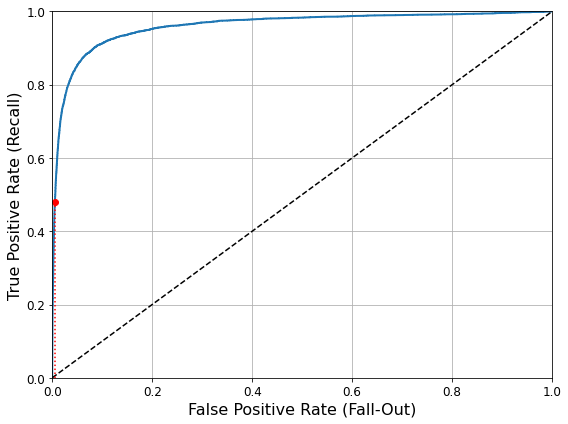

In [37]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

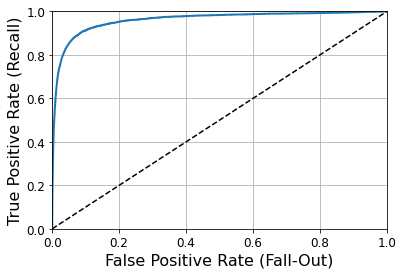

In [38]:
plot_roc_curve(fpr, tpr)
plt.show()

재현율(recall, y값, tpr)이 높을수록 분류기가 만드는 거짓양성(fpr, x값)도 같이 늘어난다. 점선은 완전한 랜덤 분류기의 ROC곡선을 뜻하므로 좋은 분류기는
이 점선에서 최대한 멀리 떨어져야한다. (시계방향 11시쪽으로 쭉)

즉 곡선 아래의 면적을 계산해서 이 면적이 클수록 더 좋은 분류기라는 것일거다 사이킷런은 ROC의 AUC를 계산하는 함수를 제공한다. (area under the curve, 곡선 아래의 면적)

In [39]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

> 일반적으로 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR곡선을 사용하고 그렇지 않은 경우 ROC곡선을 사용한다

### RandomForestClassifier를 훈련시켜 SGDClassifier과 ROC AUC를 비교해보겠다.

In [40]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [41]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

그림 저장: roc_curve_comparison_plot


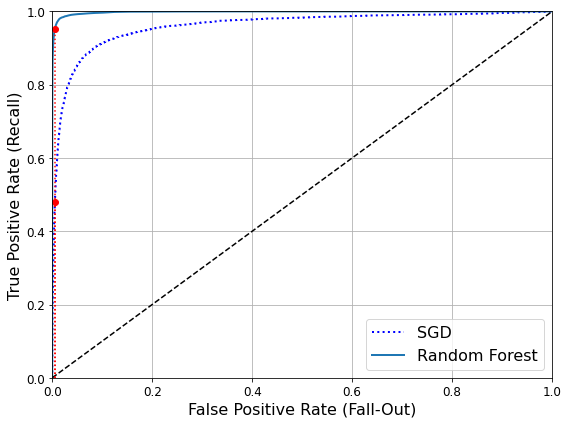

In [42]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

앞에서 언급했다시피 RandomForest가 SGD보다 더 왼쪽 상단에 위치하고있으므로 이 경우 더 좋은 분류기라 할 수 있다

## 다중분류

In [43]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [44]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [45]:
svm_clf.classes_[5]

5

사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier를 사용한다

In [46]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [47]:
len(ovr_clf.estimators_)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [48]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [49]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 에러분석

In [52]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [53]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

그림 저장: confusion_matrix_plot


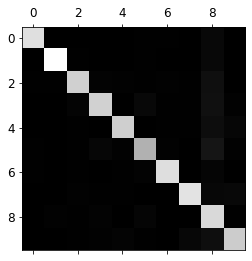

In [54]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

전체적으로 잘 맞췄다고 볼 수 있다. 이제 오차를 보려면 대각원소들을 0으로 만들어서 나머지 색들이 더 잘보이게 한다.(틀린부분)

그림 저장: confusion_matrix_errors_plot


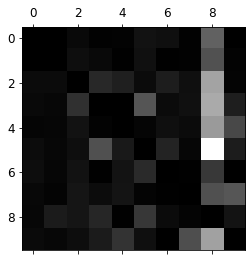

In [56]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

일단 대칭행렬이 아니라는 점은 조금만 생각해보면 알 수 있다.
8을 8이라고 분류하는 경우는 잘 하였지만 다른 숫자들을 8로 분류하는 경우가 좀 많다는 것을 확인할 수 있다.

## 다중레이블 분류

In [57]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [58]:
knn_clf.predict([some_digit])


array([[False,  True]])

7 이상인지, 홀수인지 두 가지를 파악할 수 있도록 하였고 실제로 5는 7 이하이므로 false, 홀수이므로 true가 나왔다

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

## 다중출력 분류

기존 데이터셋에 일부러 노이즈를 껴서 깨끗한 이미지를 뱉어낼 수 있도록 만들어본다

In [63]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

그림 저장: noisy_digit_example_plot


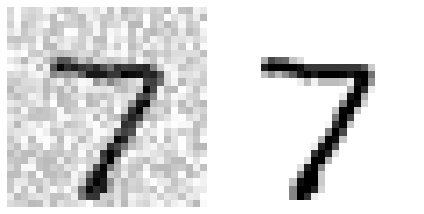

In [64]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()